# Temperature Profile
This looks at a single coordinate, evaluating whether the temperature profile is near moist adiabatic for hottest individual days, or averaged over longer e.g. week.

In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.papers.byrne_2021 import get_quant_ind
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load in data
First load in the temperature profile. Then load in the surface pressure, and compute REFHT variables.

Also, compute the LCL, and lapse rates below and above this.

In [ ]:
exp_dir = '/Users/joshduffield/Desktop/'
exp_names = ['russia', 'spain', 'australia']
n_exp = len(exp_names)
ds = [xr.load_dataset(os.path.join(exp_dir, exp_names[i]+'.nd2')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.Variable("loc", exp_names))
ds = ds.rename_vars({'TREFHT': 'TS', 'QREFHT': 'QS'})           # rename 2m variables as surface

In [4]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['PHIS']]
z2m = []
for i in range(n_exp):
    z2m.append(float(invariant_data.PHIS.sel(lat=ds.isel(loc=i).lat, lon=ds.isel(loc=i).lon, method='nearest')/g + 2))
ds['ZS'] = xr.DataArray(z2m, dims=["loc"], coords={"loc": exp_names}, name="z2m")

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0).load(), ds.hybm.isel(time=0).load(), float(ds.P0.isel(time=0))
ds['hyam'], ds['hybm'], p0 = get_lev_info()

In [5]:
refht_level_index = -3
# refht_level_index = None
ds['p'] = isca_tools.cesm.get_pressure(ds.PS, p0, ds['hyam'], ds['hybm'])
if refht_level_index is not None:
    ds['TREFHT'] = ds.T.isel(lev=refht_level_index)
    ds['QREFHT'] = ds.Q.isel(lev=refht_level_index)
    ds['PREFHT'] = ds.p.isel(lev=refht_level_index)
    ds['ZREFHT'] = ds.Z3.isel(lev=refht_level_index)
else:
    ds['TREFHT'] = ds.TS
    ds['QREFHT'] = ds.QS
    ds['PREFHT'] = ds.PS
    ds['ZREFHT'] = ds.ZS

In [6]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['mse_sat_500'] = moist_static_energy(ds.T500, sphum_sat(ds.T500, pressure_ft), ds.Z500)
ds = ds.load()

In [7]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['lev']],
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PREFHT)
ds['T_conv_neutral'] = apply_func_vec(conv_neutral_profile, ds.p, ds.T_lcl, ds.p_lcl)


# Compute constant lapse rate profile
ds_use = interp_var_at_pressure(ds.T, ds.p_lcl, ds.PS,
                                ds.hyam, ds.hybm, p0)
ds['T_at_lcl'] = ds_use.T
ds['p_at_lcl'] = ds_use.plev.transpose()
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT,
                                            ds.p_at_lcl) * 1000
ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T500.isel(plev=0), ds.p_at_lcl, float(ds.plev)) * 1000
ds['T_const_lapse'] = apply_func_vec(const_lapse_lcl_profile, ds.p, ds.TREFHT, ds.PREFHT, ds.T_at_lcl,
                                     ds.p_at_lcl, ds.lapse_below_lcl, ds.lapse_above_lcl)
ds = ds.load()

In [8]:
# Only interested between REFHT and 500hPa, so only use certain levels
if ds.lev.min()<10:          # If have not already done lev slicing, do it here
    lev_use = {'min': int(np.abs(ds.p-pressure_ft).where(ds.p<=pressure_ft).argmin(dim='lev').min())}
    lev_use['min'] -= 3     # go a bit above the 500hPa
    if refht_level_index is None or refht_level_index == -1:
        lev_use['max'] = ds.lev.size
    else:
        lev_use['max'] = refht_level_index + 1           # don't want to go below our REFHT
    ds = ds.isel(lev=slice(lev_use['min'], lev_use['max']))

### Example Temperature Profiles for hottest days
Below, I plot the temperature profiles for the hottest days for a given region, and compare against SQE and constant lapse profiles.

In [9]:
quant = 95
quant_mask = get_quant_ind(ds.TREFHT, quant, 0, np.inf,
                           return_mask=True, av_dim='time')


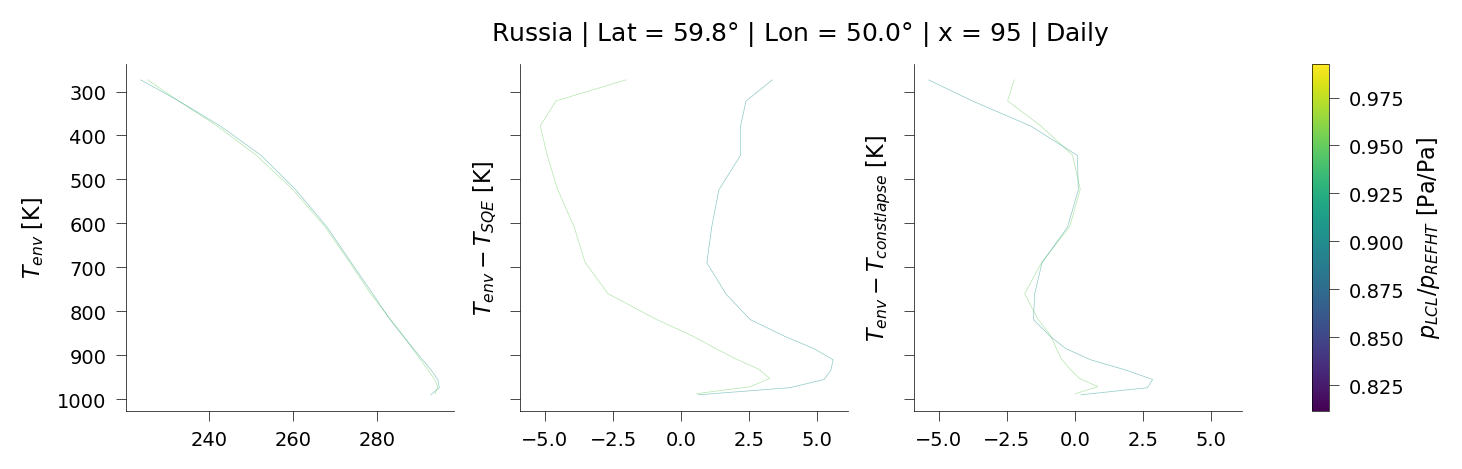

In [10]:
loc_plot = 'russia'
ds_use = ds.sel(loc=loc_plot).where(quant_mask.sel(loc=loc_plot), drop=True)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=(ds_use.p_lcl/ds_use.PREFHT).min(), vmax=(ds_use.p_lcl/ds_use.PREFHT).max())
fig, ax = plt.subplots(1, 3, sharey=True)
isca_tools.plot.fig_resize(fig, 9)
for i in range(ds_use.time.size):
    # if i not in [234, 276]:
    #     continue
    ax[0].plot(ds_use.T.isel(time=i), ds_use.p.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])), lw=ax_linewidth, alpha=0.5)
    # ax[0].plot(ds_use.T_conv_neutral.isel(time=i), ds_use.p.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #            lw=1, alpha=0.5, linestyle=':')
    # ax[0].scatter(ds_use.T_lcl.isel(time=i), ds_use.p_lcl.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #               marker='_', lw=1, s=60)
    ax[1].plot(ds_use.T.isel(time=i) - ds_use.T_conv_neutral.isel(time=i), ds_use.p.isel(time=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[2].plot(ds_use.T.isel(time=i) - ds_use.T_const_lapse.isel(time=i), ds_use.p.isel(time=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
ax[0].invert_yaxis()
ax[2].sharex(ax[1])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_ylabel('$T_{env}$ [K]')
ax[1].set_ylabel('$T_{env} - T_{SQE}$ [K]')
ax[2].set_ylabel('$T_{env} - T_{const lapse}$ [K]')
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | Daily', y=0.98, fontsize=9)
plt.show()

### Temp profile approx error
Below, I compare how good an approximation the SQE and constant lapse profiles by averaging over all pressure levels.

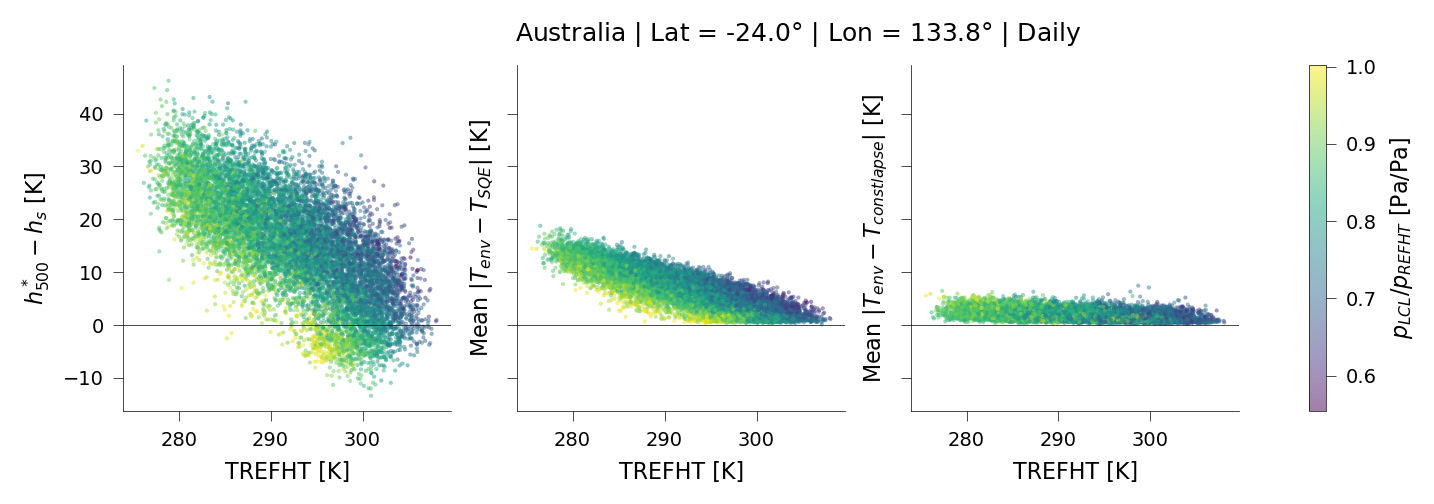

In [161]:
fig, ax = plt.subplots(1, 3, sharey=True)
isca_tools.plot.fig_resize(fig, 9)
ax[0].scatter(ds.sel(loc=loc_plot).TREFHT, -(ds.mse_REFHT-ds.mse_sat_500).sel(loc=loc_plot)*1000/c_p, alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), cmap='viridis', marker='.', s=1)
ax[1].scatter(ds.sel(loc=loc_plot).TREFHT, np.abs(ds.T-ds.T_conv_neutral).sel(loc=loc_plot).mean(dim='lev'), alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), marker='.', s=1)
im = ax[2].scatter(ds.sel(loc=loc_plot).TREFHT, np.abs(ds.T-ds.T_const_lapse).sel(loc=loc_plot).mean(dim='lev'), alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), marker='.', s=1)
ax[0].set_ylabel('$h_{500}^* - h_s$ [K]')
ax[1].set_ylabel('Mean $|T_{env} - T_{SQE}|$ [K]')
ax[2].set_ylabel('Mean $|T_{env} - T_{const lapse}|$ [K]')
for i in range(n_exp):
    ax[i].axhline(0, lw=ax_linewidth, color='k')
    ax[i].set_xlabel('TREFHT [K]')
plt.colorbar(im, label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ | Daily',
             y=0.98, fontsize=9)
plt.show()

#### Correlation between simple CAPE and SQE error
Below I show that there is a correlation between the simple CAPE proxy in terms of MSE, and the error in the SQE approximation.

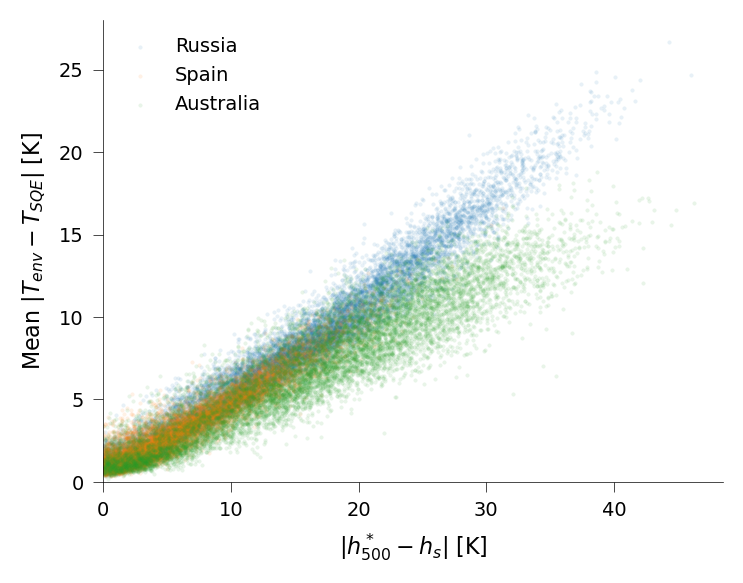

In [146]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 4)
for i in range(ds.lat.size):
    ax.scatter(np.abs(ds.mse_REFHT-ds.mse_sat_500).isel(loc=i)*1000/c_p, np.abs(ds.T-ds.T_conv_neutral).isel(loc=i).mean(dim='lev'), alpha=0.1,
               color=f"C{i}", label=exp_names[i].capitalize(), marker='.', s=1)
ax.set_xlabel('$|h_{500}^* - h_s|$ [K]')
ax.set_ylabel('Mean $|T_{env} - T_{SQE}|$ [K]')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()
plt.show()